# Offshore Oil and Gas Energy System Operation (OOGESO)
# Test platform v1 (Nov 2020)
Representing a hypothetical, but realistic Norwegian offshore oil and gas platform

* wellstream: 50 Sm3/s, of which:
    * gas: 49.75 Sm3/s = 4.3 mill Sm3/day = 4300 Sm3oe/day
    * oil:  0.1 Sm3/s = 8640 Sm3/day  
    * water: 0.15 Sm3/s = 12960 Sm3/day 

Gas oil ratio and water cut (standard units):
* GOR = 4.3 mill/8640 = 497
* WC = 12960/(12960+8640) = 0.6


In [2]:
%load_ext autoreload
%autoreload 2
from oogeso import multicarrier
from oogeso import plots
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import logging
import pprint
import ipywidgets
import cloudpickle
import plotly.express as px
import pyomo.environ as pyo

## Read input data

In [26]:
#case='1' # base case without wind
case='1a' # case with 24 MW wind capacity
#case='1b' # case with 24 MW wind capacity AND 4 MW, 4 MWh battery
#timerange=[0,12*24*7] #one week (with 5 min timestep)
timerange=[0,40] # testing
outpath = "result/"
pickle_save='{}case{}.pkl'.format(outpath,case)
plots.plotter="plotly"

mc = multicarrier.Multicarrier(loglevel=logging.INFO,quadraticConstraints=False)
data = multicarrier.read_data_from_yaml('testplatform.yaml')
profiles = multicarrier.read_profiles_from_xlsx('testplatform_profiles.xlsx')

for dev in ['Gen1','Gen2','Gen3']:
    data['paramDevice'][dev]['isOn_init'] = 1

if case=='1':
    data['paramDevice']['wind']['Pmax']=0 # no wind
elif case=='1a':
    data['paramDevice']['wind']['Pmax']=8*3 # 3x8 MW, as agreed with ABB
elif case=='1b':
    data['paramDevice']['wind']['Pmax']=8*3 # 3x8 MW, as agreed with ABB
    data['paramDeviceEnergyInitially']['battery'] = data['paramDevice']['battery']['Emax']


# fixed production - not allowed to reduce:
data['paramDevice']['wellL1']['Qmin'] = data['paramDevice']['wellL1']['Qmax']
data['paramDevice']['wellL2']['Qmin'] = data['paramDevice']['wellL2']['Qmax']
# modify reserve requirements:
#data['paramParameters']['elReserveMargin'] = 4 #accept 4MW load loss
#data['paramParameters']['elReserveMargin'] = 0 #accept no load loss (100% backup)
#data['paramParameters']['elReserveMargin'] = -1 #skip constraint
#data['paramParameters']['elBackupMargin'] = 5 #available unused power

data = multicarrier.create_initdata(data)
instance = mc.createModelInstance(data,profiles)
#print("Writing instance to file.")
#instance.pprint(outpath+"problem_instance.txt")

INFO:root:TODO: separator power (eta) and heat (eta2) demand
INFO:root:TODO: gas turbine power vs heat output
INFO:root:TODO: startup cost
INFO:root:TODO: el source: dieselgen, fuel, on-off variables
INFO:root:TODO: liquid pump approximation ok?
INFO:root:TODO: flow vs pressure equations for liquid flows
INFO:root:Valid elBackupMargin not defined -> no constraint


### Inspect input data

In [165]:
xx=['','paramNode','paramEdge','paramDevice','paramCarriers','paramParameters','setProfile']
#xx=['']+list(data.keys())
@ipywidgets.interact(datagroup=xx)
def showdata(datagroup):
    pprint.pprint(data[datagroup],width=1) if datagroup!='' else print('')

interactive(children=(Dropdown(description='datagroup', options=('', 'paramNode', 'paramEdge', 'paramDevice', …

In [10]:
# View profiles (entire available time windows)
#plots.plotProfiles(profiles,filename=None)

In [13]:
fuelA = data['paramDevice']['Gen1']['fuelA']
fuelB = data['paramDevice']['Gen1']['fuelB']
Pmax = data['paramDevice']['Gen1']['Pmax']
#plots.plotGasTurbineEfficiency(filename='gasturbine_Gen1.png',fuelA=fuelA,fuelB=fuelB,Pmax=Pmax)

In [169]:
# View energy system
dotG=plots.plotNetwork(mc,timestep=None,filename=None)
IPython.display.Image(dotG.create_png()) #scales automatically to page width

### Some checks on input data

In [15]:
print("flow per pipe = {:.4} Sm3/s".format(50/15))
flow1=multicarrier.Multicarrier.darcy_weissbach_Q(p1=6.164,p2=6,f=0.001,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow2=multicarrier.Multicarrier.darcy_weissbach_Q(p1=6.164,p2=4,f=0.0136,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow3=multicarrier.Multicarrier.darcy_weissbach_Q(p1=7,p2=4,f=0.0189,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
print("flow1 (6.164->6): {:.4}".format(flow1))
print("flow2 (6.164->4): {:.4}".format(flow2))
print("flow3 (7->4):     {:.4}".format(flow3))

flow per pipe = 3.333 Sm3/s
flow1 (6.164->6): 3.333
flow2 (6.164->4): 3.336
flow3 (7->4):     3.333


In [18]:
# Water pipe pressure drop ('w3')
#mc.instance.paramEdge['w3']['num_pipes']=15
#mc.instance.paramEdge['w1']['diameter_mm']=200
print("Pressure out={:.4} MPa".format(mc.compute_edge_pressuredrop(mc.instance,'w1',p1=1.14,Q=1.15/3,linear=False)))
print(mc.instance.paramEdge['w1'])

Pressure out=0.6981 MPa
{'height_m': 40.0, 'include': 1, 'length_km': 0.01, 'nodeFrom': 'waterlift', 'nodeTo': 'pump_water', 'pressure.from': 1.14, 'pressure.to': 0.7, 'type': 'water', 'diameter_mm': 200.0, 'num_pipes': 3.0}


## Solve

If the problem is infeasible, try 
* relaxing pressure deviation limits (generic value and per-node value)
* add a high cost emergency generator (that could represent load shedding) to ensure energy balance can be satisfied
* make sure excess heat/water/gas has a place to go


In [30]:
status = mc.solveMany(solver="cbc",timerange=timerange,write_yaml=False,timelimit=60)

sumCO2 = mc._dfCO2rate.mean()
co2intensity = mc._dfCO2intensity.mean()
exportrevenue = mc._dfExportRevenue.mean()
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(sumCO2))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(co2intensity))
print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in mc._dfExportRevenue.mean().items() if v!=0],"$/s")

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]

Mean CO2 emission rate      = 6.8 kgCO2/s
Mean CO2 emission intensity = 47.4 kgCO2/Sm3oe
Mean export revenue         = gas:192.7  oil:409.8  $/s


## Save/Load simulation results
By saving to pickle file, it easy to later open and analyse the results without having to re-run the simulation

In [32]:
# Save (pickle) - for later opening and analysis
with open(pickle_save, mode='wb') as file:
   cloudpickle.dump(mc, file)
print("Results were saved to {}".format(pickle_save))

Results were saved to result/case1a.pkl


In [33]:
# Open previously saved object (including simulation results)
#with open(pickle_save, mode='rb') as file:
#   mc = cloudpickle.load(file)

## Analyse results

In [41]:
kpi = mc.compute_kpis(windturbines=['wind'])
kpi = pd.DataFrame.from_dict(kpi,orient="index",columns=[case])
kpi

,1a
hours_simulated,3.500000e+00
kgCO2_per_year,2.147306e+08
kgCO2_per_Sm3oe,4.735740e+01
gt_fuel_sm3_per_year,9.176520e+07
elconsumption_mwh_per_year,3.580722e+05
gt_starts_per_year,5.005714e+03
gt_stops_per_year,7.508571e+03
gt_hoursrunning_per_year,2.252571e+05
wind_output_mwh_per_year,2.900276e+04
wind_curtailed_mwh_per_year,2.913371e-05


In [ ]:
tstep=16
gCombined = plots.plotNetwork(mc,timestep=tstep,numberformat="{:.3g}",
    filename=outpath+"network_combined.png")
IPython.display.Image(gCombined.create_png())

In [65]:
print("CHECKING edge pressure drop on selected edges:")
print('w1: {:.5g} MPa'.format(mc.compute_edge_pressuredrop(mc.instance,edge='w1',Q=1.15,p1=0.7,linear=True)))
print('w3: {:.5g} MPa'.format(mc.compute_edge_pressuredrop(mc.instance,edge='w3',Q=1.3/15,p1=7,linear=False)))
print('o2: {:.5g} MPa'.format(mc.compute_edge_pressuredrop(mc.instance,edge='o2',Q=0.1,p1=5,linear=True)))
print('g2: {:.5g} MPa'.format(mc.compute_edge_pressuredrop(mc.instance,edge='g2',Q=48,p1=10,linear=True)))

CHECKING edge pressure drop on selected edges:
w1: 0.10778 MPa
w3: 6.1178 MPa
o2: 2.7294 MPa
g2: 5.8895 MPa


In [62]:
mc.checkEdgePressureDrop(timestep=1,var="outer")

gas edge cL1:compressor_lift-wells ---
gas edge cL2g:wells-separator --
oil edge cL2o:wells-separator --
water edge cL2w:wells-separator --
gas edge g1:separator-compressor_gas ---
gas edge g2:compressor_gas-export gas edge g2:compressor_gas-export
gas edge g2:compressor_gas-export (Q=47.255382 m3/s)
	NOMINAL:    pin=10.0  pout=6.0  pout_computed=6.0563 pout_linear=6.0567
	SIMULATION: pin=9.9659619  pout=6.0  pout_computed=5.9999 pout_linear=  6
	flow velocity = 18.842 m/s
gas edge g3:separator-powersupply ---
gas edge gL1:separator-compressor_lift ---
oil edge o1:separator-pump_oil ---
oil edge o2:pump_oil-export oil edge o2:pump_oil-export
oil edge o2:pump_oil-export (Q=0.099944397 m3/s)
	NOMINAL:    pin=5.0  pout=3.0  pout_computed=2.9775 pout_linear=2.7318
	SIMULATION: pin=5.2682007  pout=3.0  pout_computed=3.2457 pout_linear=  3
	flow velocity = 3.1813 m/s
water edge w0:water_intake-waterlift ---
water edge w1:waterlift-pump_water water edge w1:waterlift-pump_water
water edge w1:w

In [ ]:
plots.plotter='plotly'
fig2=plots.plot_SumPowerMix(mc,carrier="el",filename=None)
fig2.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=0,b=0))
#fig2.write_image("{}/elpowermix_{}.png".format(outpath,case))

,el,heat
ACO,3.500000,NaN
OEX,0.766146,NaN
PQ_load,3.000000,NaN
REC,11.944521,NaN
SEP_2,3.533235,4.946529
SWL,1.161279,NaN
WIN,8.190000,NaN
WST_lift,8.780636,NaN
heat1,NaN,3.000000


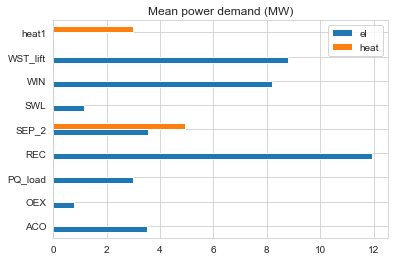

In [82]:
mean_el_demand = mc._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_heat_demand = mc._dfDeviceFlow.unstack('carrier')['heat'].unstack('terminal')['in'].dropna().unstack().T.mean()
energydemand = pd.concat({'el':mean_el_demand,'heat':mean_heat_demand},axis=1)
energydemand.drop('heatdump',inplace=True)
energydemand.plot.barh(title="Mean power demand (MW)")
energydemand

In [85]:
print("Gas flow out ot terminal:")
mc._dfDeviceFlow.unstack('carrier')['gas'].unstack('terminal')['out'].dropna().unstack().T.mean()

Gas flow out ot terminal:


device
REC         45.993055
SEP_2       70.420191
WST_lift    21.517280
wellL1      21.126057
wellL2      49.294134
dtype: float64

In [91]:
well_inout=mc._dfDeviceFlow.unstack('device')[['wellL1','wellL2']].sum(axis=1).unstack('time').mean(axis=1).unstack('terminal')
print("Net gas production = {:.5g} Sm3/s".format((well_inout['out']-well_inout['in']).sum()))
print("Gas circulated =     {:.5g} Sm3/s".format(well_inout['in'].sum()))

Net gas production = 49.147 Sm3/s
Gas circulated =     21.517 Sm3/s


In [92]:
# Check DUALS ()
# display all duals
for c in instance.component_objects(pyo.Constraint, active=True):
    if len(c)>0:
        print ("   Constraint",c, (len(c)))
        ci=list(c)[0:6]
        for index in ci:
            thedual=instance.dual[c[index]]
            if thedual!=0:
                print ("      ", index, thedual)

   Constraint constrDevice_well_gaslift 384
       ('wellL1', 'oil', 0, 2) -172.8374
       ('wellL1', 'oil', 1, 2) -172.8374
       ('wellL1', 'oil', 2, 2) -172.8374
   Constraint constrDevice_separator2 192
       ('SEP_2', 'oil', 0, 1) -174.4696
       ('SEP_2', 'oil', 0, 3) 0.014519006
       ('SEP_2', 'oil', 0, 4) -1.7347235e-18
       ('SEP_2', 'oil', 1, 1) -174.4696
   Constraint constrDevice_compressor_el 96
       ('REC', 0, 1) 0.16902689
       ('REC', 0, 2) 0.014519006
       ('REC', 1, 1) 0.16902689
       ('REC', 1, 2) 0.014519006
       ('REC', 2, 1) 0.16902689
       ('REC', 2, 2) 0.014519006
   Constraint constrDevice_gasturbine 144
       ('Gen1', 0, 1) 0.13462966
       ('Gen1', 1, 1) 0.13462966
       ('Gen1', 2, 1) 0.13462966
   Constraint constrDevice_source_water 24
   Constraint constrDevice_pump_oil 48
       ('OEX', 0, 1) -174.58333
       ('OEX', 0, 2) 0.014519006
       ('OEX', 1, 1) -174.58333
       ('OEX', 1, 2) 0.014519006
       ('OEX', 2, 1) -174.58333


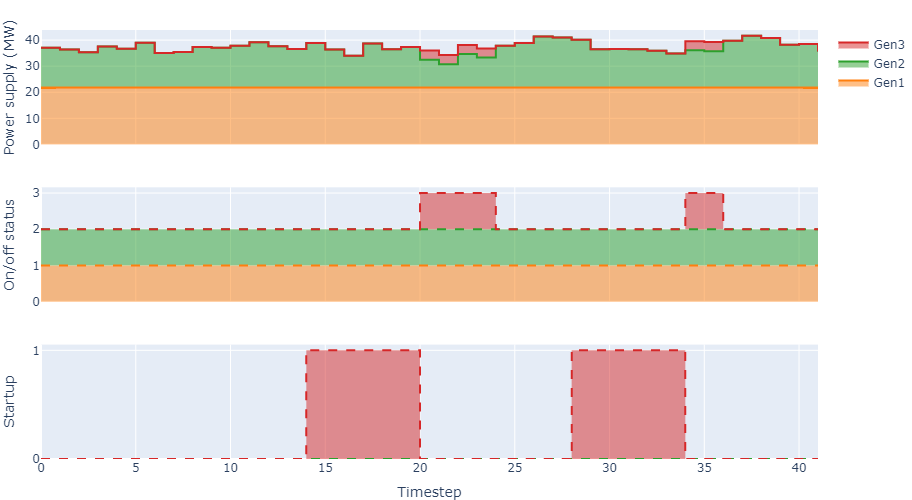

In [94]:
plots.plotter="plotly"
gts = [d for d in mc.instance.setDevice 
       if mc.instance.paramDevice[d]['model']=='gasturbine']
fig=plots.plot_deviceprofile(mc,devs=gts,filename=None,includeOnOff=True,includePrep=True)
fig.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=30,b=0))

In [107]:
# Print constraint for last rolling horizon optimisation
gt='Gen2'
print("GT is on initially ={}".format(pyo.value(mc.instance.paramDeviceIsOnInitially[gt])))
print("GT timesteps in startup preparation = {}".format(pyo.value(mc.instance.paramDevicePrepTimestepsInitially[gt])))
for t in range(6):
    cstr=mc.instance.constrDevice_startup_shutdown[gt,t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))

GT is on initially =1.0
GT timesteps in startup preparation = 0
t=0: varDeviceIsOn[Gen2,0] - paramDeviceIsOnInitially[Gen2] + varDeviceStopping[Gen2,0] = 0.0
t=1: varDeviceIsOn[Gen2,1] - varDeviceIsOn[Gen2,0] + varDeviceStopping[Gen2,1] = 0.0
t=2: varDeviceIsOn[Gen2,2] - varDeviceIsOn[Gen2,1] + varDeviceStopping[Gen2,2] = 0.0
t=3: varDeviceIsOn[Gen2,3] - varDeviceIsOn[Gen2,2] + varDeviceStopping[Gen2,3] = 0.0
t=4: varDeviceIsOn[Gen2,4] - varDeviceIsOn[Gen2,3] + varDeviceStopping[Gen2,4] = 0.0
t=5: varDeviceIsOn[Gen2,5] - varDeviceIsOn[Gen2,4] + varDeviceStopping[Gen2,5] = 0.0


In [110]:
dfStartopt = pd.DataFrame()
for t in mc.instance.setHorizon: 
    dfStartopt.loc[t,'start']=mc.instance.varDeviceStarting['Gen2',t].value
    dfStartopt.loc[t,'prep']=mc.instance.varDeviceIsPrep['Gen2',t].value
    dfStartopt.loc[t,'on']=mc.instance.varDeviceIsOn['Gen2',t].value
    dfStartopt.loc[t,'stop']=mc.instance.varDeviceStopping['Gen2',t].value
#dfStartopt

In [31]:
plots.plotter='plotly'
#plots.plotter='matplotlib'

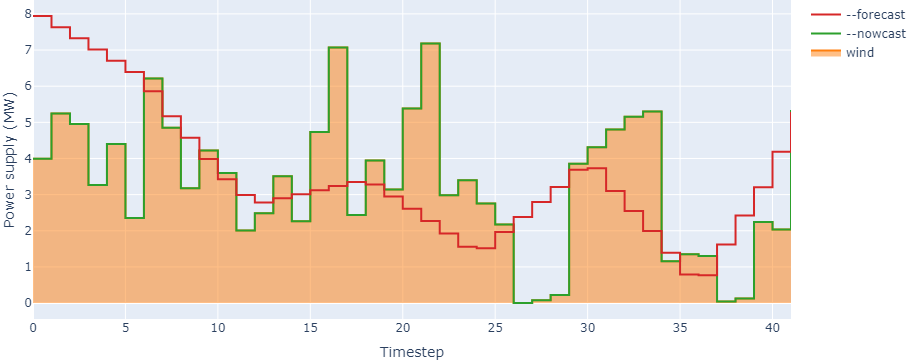

In [109]:
fig=plots.plot_deviceprofile(mc,devs=['wind'],filename=None,includeForecasts=True)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

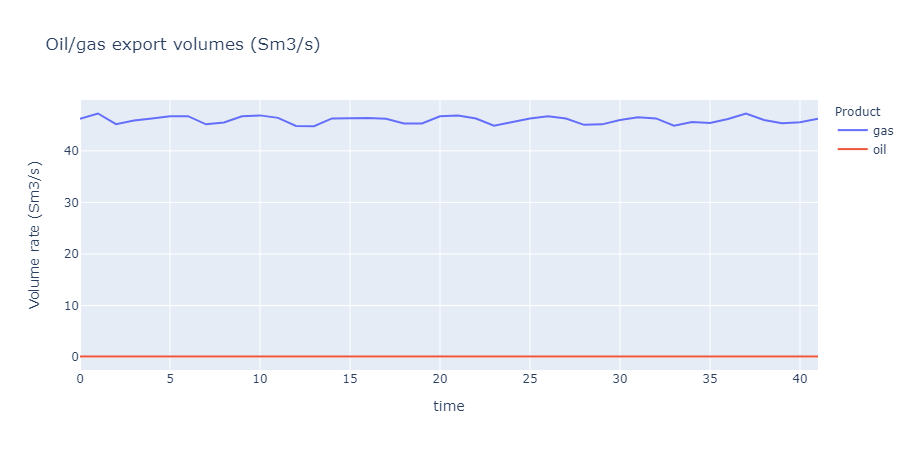

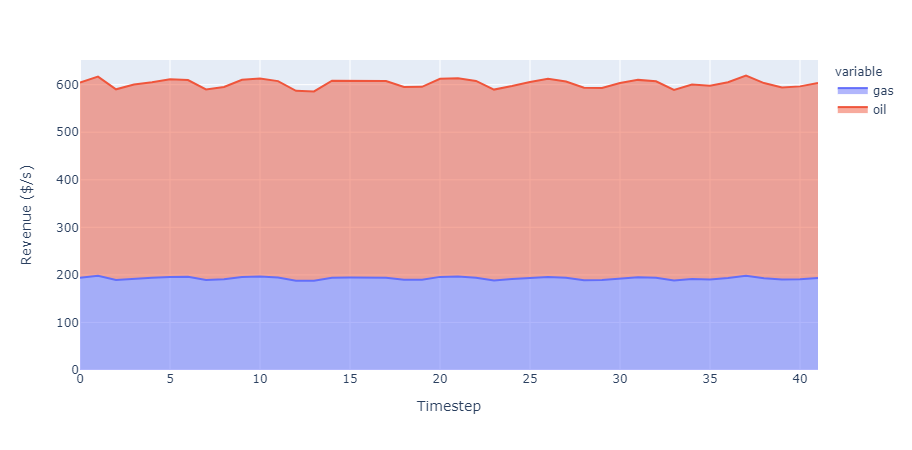

In [140]:
df=mc._dfDeviceFlow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
df.columns=['gas','oil']
df=df.reset_index()
df = df.melt(var_name="Product",value_name="Volume rate (Sm3/s)",id_vars=('time'))
px.line(df,x="time",y="Volume rate (Sm3/s)",color="Product",title="Oil/gas export volumes (Sm3/s)").show()

plots.plot_ExportRevenue(mc)

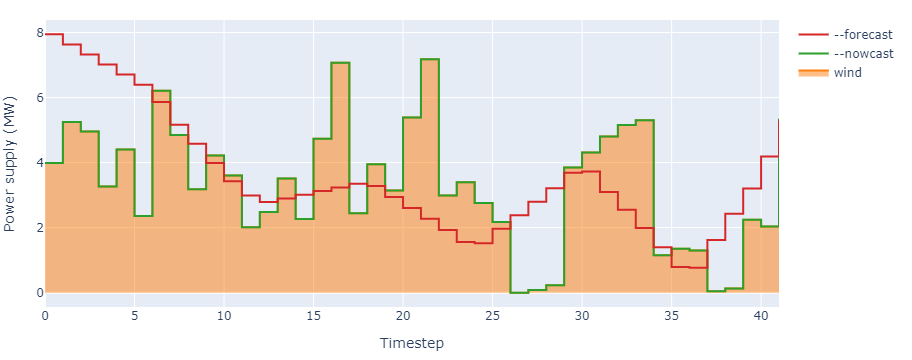

In [142]:
plots.plotter="plotly"
fig=plots.plot_deviceprofile(mc,devs=['wind'],includeForecasts=True,includeOnOff=False,
                             filename=None)#outpath+"WT_opt.png")
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),width=800,height=300)
fig.show()

In [28]:
plots.plotter="plotly"
if 'battery' in mc.instance.setDevice:
    fig=plots.plot_devicePowerEnergy(mc,'battery',
                                 filename=None)#outpath+"battery_opt.png")
    fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()
    multicarrier.Plots.plotDevicePowerLastOptimisation1(mc,device='battery',
                filename=None)#outpath+"lastopt_battery.png")

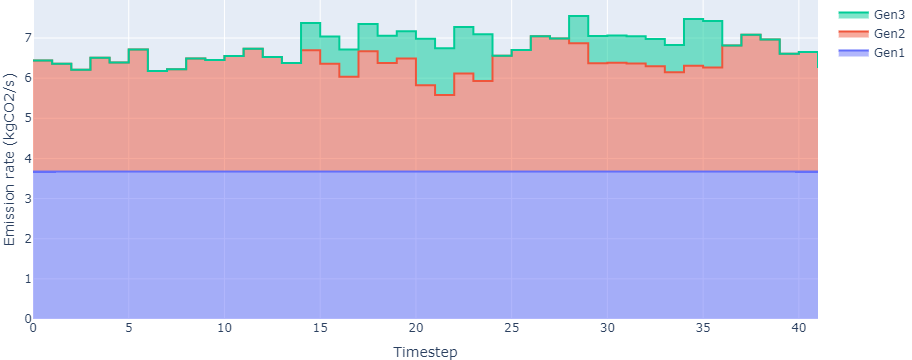

In [143]:
plots.plotter="plotly"
fig=plots.plot_CO2rate_per_dev(mc,reverseLegend=True,filename=outpath+"co2rate_opt.png")
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

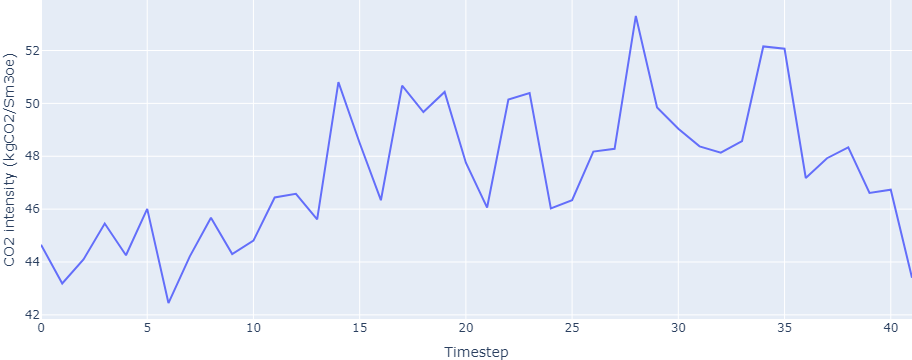

In [144]:
fig=plots.plot_CO2_intensity(mc,filename=outpath+"co2intensity_opt.png")
fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=0,b=0))

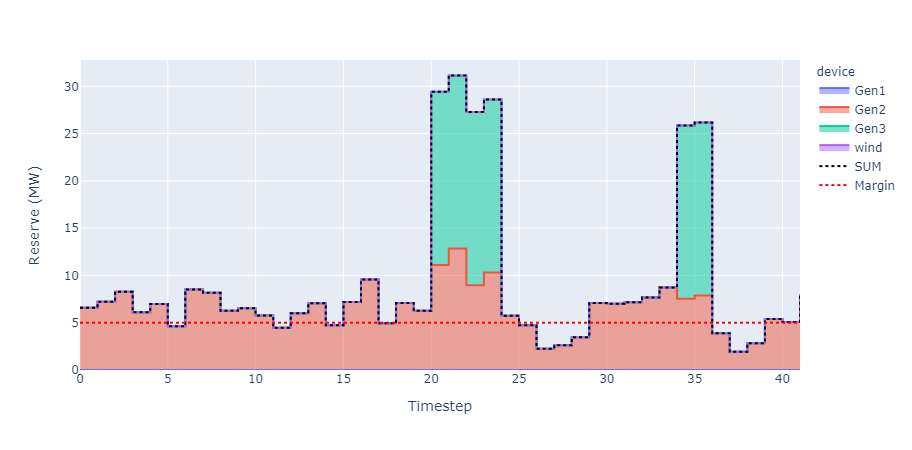

In [148]:
plots.plotReserve(mc,dynamicMargin=True)

In [166]:
# This plot shows per device its output (dotted line) and the available online backup, iel reserve 
# by _other_ devices (solid line). MARGIN(t) = min_devices(backup(t) - output(t))
#plots.plotElBackup(mc,showMargin=True,returnMargin=False)